# LGBM

In [ ]:
!pip install lightgbm

source: Error encountered while sourcing file '/usr/local/opt/nvm/nvm.sh':
source: No such file or directory
     |████████████████████████████████| 1.2 MB 8.8 MB/s 


In [72]:
import lightgbm as lgbm

from functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

sns.set_theme(style="darkgrid")


In [2]:
flights_test = pd.read_csv('./flights_test.csv')
flights_train = pd.read_csv('./flights_train.csv')

flights_train = flights_train.sort_values(['AIRLINE', 'FLIGHT_NUMBER']).fillna(method='backfill')
flights_test = flights_test.sort_values(['AIRLINE', 'FLIGHT_NUMBER']).fillna(method='backfill')

print(len(flights_test))
print(len(flights_train))

514384
2818553


In [5]:
flights_train = preprocessing(flights_train)
flights_test = preprocessing(flights_test)

## Feature selection with LGBM

In [6]:
training_set = flights_train.sample(200000)

training_set.columns

features_train = ['MONTH', 'DAY', 'DAY_OF_WEEK',
                  'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF',
                  'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL',
                  #  'scheduled_departure_date_time',
                  #  'scheduled_departure_date',
                  'scheduled_departure_timestamp',
                  #  'departure_date_time',
                  'departure_timestamp',
                  'initial_delay']

target_train = 'ARRIVAL_DELAY'

categorical_features = ['AIRLINE', 'FLIGHT_NUMBER',
                        'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

X_train, X_val, y_train, y_val = train_test_split(
    training_set[features_train], training_set[target_train], test_size=0.2)


In [7]:
train_data = lgbm.Dataset(X_train, label=y_train)#, categorical_feature=categorical_features)

test_data = lgbm.Dataset(X_val, label=y_val)#, categorical_feature=categorical_features)

[1]	valid_0's l2: 1653.4
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1653.19
[3]	valid_0's l2: 1652.77
[4]	valid_0's l2: 1652.33
[5]	valid_0's l2: 1651.93
[6]	valid_0's l2: 1651.21
[7]	valid_0's l2: 1650.52
[8]	valid_0's l2: 1650.42
[9]	valid_0's l2: 1649.83
[10]	valid_0's l2: 1649.22
[11]	valid_0's l2: 1649.08
[12]	valid_0's l2: 1648.95
[13]	valid_0's l2: 1648.38
[14]	valid_0's l2: 1648.2
[15]	valid_0's l2: 1647.93
[16]	valid_0's l2: 1647.82
[17]	valid_0's l2: 1647.31
[18]	valid_0's l2: 1647.26
[19]	valid_0's l2: 1647.02
[20]	valid_0's l2: 1646.58
[21]	valid_0's l2: 1646.17
[22]	valid_0's l2: 1645.78
[23]	valid_0's l2: 1645.6
[24]	valid_0's l2: 1645.5
[25]	valid_0's l2: 1645.39
[26]	valid_0's l2: 1645.34
[27]	valid_0's l2: 1645.27
[28]	valid_0's l2: 1645.21
[29]	valid_0's l2: 1645.13
[30]	valid_0's l2: 1644.78
[31]	valid_0's l2: 1644.45
[32]	valid_0's l2: 1644.14
[33]	valid_0's l2: 1644.07
[34]	valid_0's l2: 1643.78
[35]	valid_0's l2: 1643.72
[36]	

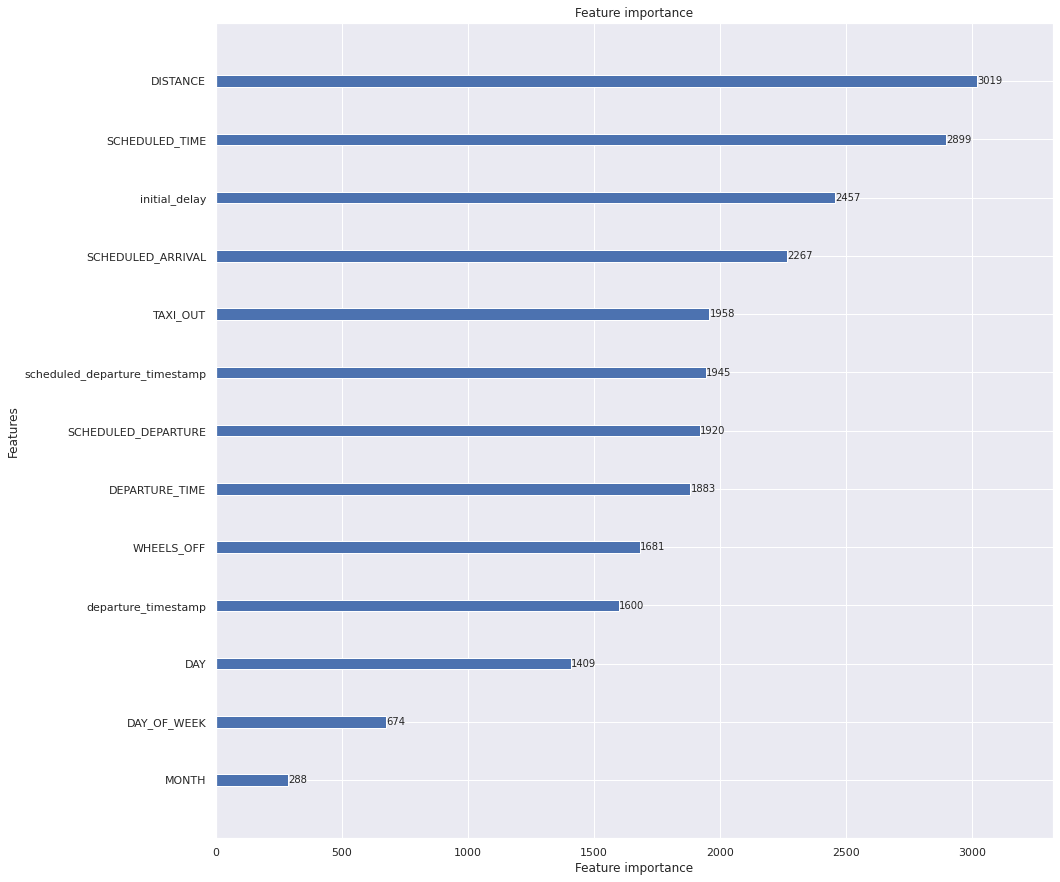

In [8]:
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'mse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=1000,
                       early_stopping_rounds=100)


ax = lgbm.plot_importance(model, max_num_features=40, figsize=(15, 15))
plt.show()


## LGBM Regressor

In [48]:
important_features = ['DISTANCE', 'SCHEDULED_TIME', 'initial_delay', 'initial_delay_mean',
                      'SCHEDULED_ARRIVAL', 'scheduled_departure_timestamp',
                      'TAXI_OUT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
                      'WHEELS_OFF', 'departure_timestamp', 'DAY']

training_set = flights_train.sample(300000)

X_train, X_val, y_train, y_val = train_test_split(training_set[important_features], training_set['ARRIVAL_DELAY'], test_size=0.2)

In [103]:
# param_grid = {
#     'max_depth': [1,3,5,7,9,10],
#     'min_data_in_leaf': [5, 10, 15, 20],
#     'feature_fraction': [0.2, 0.4, 0.6, 0.8],
#     'bagging_fraction': [],
#     'early_stopping_round': [50, 100],
#     'lambda': [0, 0.5, 1],
#     'min_gain_to_split': [],
#     'boosting': ['gbdt', 'rf'],
#     'num_boost_round': [100, 150, 200],
#     'learning_rate': [0.01, 0.003, 0.001],
#     'num_leaves': [10, 15, 20, 25, 30],
#     'metric': ['mse']
#     # 'criterion': ['gini', 'entropy']
# }
# {'learning_rate': 0.003, 'max_depth': 25, 'metric': 'mse', 'min_data_in_leaf': 500, 'num_leaves': 35} -> MSE 983.560
# {'learning_rate': 0.005, 'max_depth': 15, 'metric': 'mse', 'min_data_in_leaf': 300, 'num_leaves': 40} -> MSE 719.125
# {'learning_rate': 0.008, 'max_depth': 10, 'metric': 'mse', 'min_data_in_leaf': 150, 'num_leaves': 50} -> MSE 466.621
# {'learning_rate': 0.02, 'max_depth': 9, 'metric': 'mse', 'min_data_in_leaf': 70, 'num_leaves': 70} -> MSE 176.565

reg = lgbm.LGBMRegressor(
    random_state=420,
    metric='mse',
    learning_rate=0.02,
    max_depth=9,
    min_data_in_leaf=70,
    num_leaves=70,
    # feature_fraction=0.8,
    boosting='gbdt'
    )
reg.fit(X_train, y_train)

LGBMRegressor(boosting='gbdt', learning_rate=0.02, max_depth=9, metric='mse',
              min_data_in_leaf=70, num_leaves=70, random_state=420)

In [104]:
y_pred = reg.predict(X_val[important_features])

predictions = pd.DataFrame({'predicted': y_pred, 'actual': y_val})

In [105]:
mse(predictions['actual'], predictions['predicted'])

176.56594509892807

## Hyperparameter Tuning

In [102]:
param_grid = {
    'max_depth': [9, 10],
    'min_data_in_leaf': [70, 75],
    # 'feature_fraction': [0.6, 0.8],
    # 'bagging_fraction': [],
    # 'early_stopping_round': [50, 100],
    # 'lambda': [0, 0.5, 1],
    # 'min_gain_to_split': [],
    # 'num_boost_round': [100, 150, 200],
    'learning_rate': [0.01, 0.02],
    'num_leaves': [50, 70],
    'metric': ['mse']
}

CV = GridSearchCV(estimator=lgbm.LGBMRegressor(random_state=420), param_grid=param_grid, cv=5)
CV.fit(X_train, y_train)
print(CV.best_params_)
print(CV.best_score_)

{'learning_rate': 0.02, 'max_depth': 9, 'metric': 'mse', 'min_data_in_leaf': 70, 'num_leaves': 70}
0.8907741748152389


### Creating Submission

In [ ]:
predictions = reg.predict(flights_test[important_features])

submission = pd.DataFrame({'id': flights_test['id'], 'ARRIVAL_DELAY': predictions})
submission.to_csv('submissions/submission_5_LGBM.csv', index=False)

# submission must have 514,384 rows
print(len(submission))

514384
